### Load necessary files and packages

In [1]:
from google.colab import files
uploaded = files.upload()

Saving trainPart1.zip to trainPart1.zip


In [ ]:
!unzip trainPart1.zip

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from sklearn.preprocessing import LabelEncoder

### Create Dataset

In [2]:
ROOT_DIR = 'train'
labels = []
images = []
all_labels = os.listdir(ROOT_DIR)
for label in all_labels:
  path = [os.path.join(ROOT_DIR, label, p) for p in os.listdir(os.path.join(ROOT_DIR, label))]
  for p in path:
    image = cv2.imread(p)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (60, 45))
    images.append(image)
    labels.append(label)

In [3]:
images = np.asarray(images)/255
images = np.expand_dims(images, -1)
labels = np.asarray(labels)

In [4]:
images.shape, labels.shape

((2480, 45, 60, 1), (2480,))

As the number of total samples in the dataset is very less, i.e. 2,480, more samples are created by Data Augmentation techniques. <br />
Random Translation and Rotation is done to create new data sample

In [5]:
data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomTranslation((-0.1, 0.1), (-0.1, 0.1)),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)])

augmented_dataset = None

for i in range(25):
  augmented_image = data_augmentation(images)
  if augmented_dataset is None:
    augmented_dataset = augmented_image
    augmented_labels = labels
  else:
    augmented_dataset = np.vstack([augmented_dataset, augmented_image])
    augmented_labels = np.hstack([augmented_labels, labels])

Encode the labels. <br />Encoding is done to convert the string labels into integer encodings so that they can be accepted by the tensorflow model.

In [6]:
le = LabelEncoder()
augmented_labels = le.fit_transform(augmented_labels)

In [7]:
augmented_dataset.shape, augmented_labels.shape

((62000, 45, 60, 1), (62000,))

### Train-Test Split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(augmented_dataset, augmented_labels, test_size=0.2, random_state=42)

In [9]:
x_train.shape

(49600, 45, 60, 1)

### Model Creation & Training

In [10]:
def Model(image, label, dropout=0.25):
  print(image)
  _input = tf.keras.layers.Input(shape=image)

  x = tf.keras.layers.Conv2D(16, (3, 3))(_input)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  
  x = tf.keras.layers.MaxPool2D()(x)

  x = tf.keras.layers.Conv2D(32, (3, 3))(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  
  x = tf.keras.layers.MaxPool2D()(x)

  x = tf.keras.layers.Conv2D(64, (3, 3))(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  
  # x = tf.keras.layers.MaxPool2D()(x)

  x = tf.keras.layers.Flatten()(x)

  x = tf.keras.layers.Dense(256)(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.Dense(128)(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.Dense(label)(x)
  x = tf.keras.layers.Activation(tf.nn.softmax)(x)
  return tf.keras.Model(_input, x)

Summary of the model

In [11]:
model = Model(x_train[0].shape, len(all_labels))
model.summary()

(45, 60, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 45, 60, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 43, 58, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 43, 58, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 43, 58, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 43, 58, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 29, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 27, 32)  

In [12]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = model.fit(x_train, y_train, validation_split=0.25, epochs=500, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/500
146/146 [==============================] - 38s 49ms/step - loss: 3.5156 - accuracy: 0.1685 - val_loss: 5.8307 - val_accuracy: 0.0248
Epoch 2/500
146/146 [==============================] - 6s 43ms/step - loss: 1.6888 - accuracy: 0.5278 - val_loss: 7.1859 - val_accuracy: 0.0433
Epoch 3/500
146/146 [==============================] - 6s 43ms/step - loss: 1.1610 - accuracy: 0.6529 - val_loss: 5.4284 - val_accuracy: 0.0908
Epoch 4/500
146/146 [==============================] - 6s 43ms/step - loss: 0.9272 - accuracy: 0.7113 - val_loss: 2.5140 - val_accuracy: 0.3134
Epoch 5/500
146/146 [==============================] - 6s 43ms/step - loss: 0.7816 - accuracy: 0.7545 - val_loss: 3.3780 - val_accuracy: 0.2420
Epoch 6/500
146/146 [==============================] - 6s 43ms/step - loss: 0.6966 - accuracy: 0.7750 - val_loss: 3.6211 - val_accuracy: 0.3472
Epoch 7/500
146/146 [==============================] - 6s 43ms/step - loss: 0.6357 - accuracy: 0.7885 - val_loss: 0.8694 - val_accuracy

Plot of the train history (X-axis: <i>EPOCHS</i>, Y-axis: <i>ACCURACY</i>)

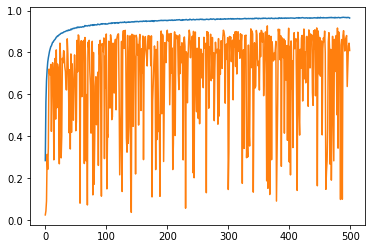

In [13]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

Load the model with best weights for evaluation

In [14]:
model.load_weights('weights/')
print("Train Accuracy:", model.evaluate(x_train, y_train, verbose=0)[1], "Test Accuracy:", model.evaluate(x_test, y_test, verbose=0)[1])

Train Accuracy: 0.9790524244308472 Test Accuracy: 0.9265322685241699
